# Experiments with LogRegression

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd

from tqdm import tqdm

In [125]:
def to_seconds(time):
    return time.microseconds * 1e-6 + time.seconds

def f(w, X, y):
    res = 0
    for i in range(X.shape[0]):
        res += np.log(1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def grad_f(w, X, y, batch_size):
    a = np.arange(X.shape[0])
    np.random.shuffle(a)
    a = a[:batch_size]
    X = X[a]
    y = y[a]
    
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def grad_grad_f(w, X, y, batch_size):
    a = np.arange(X.shape[0])
    np.random.shuffle(a)
    a = a[:batch_size]
    X = X[a]
    y = y[a]
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += (X[i])**2 * np.exp(-w.dot(X[i]) * y[i])*(1/(1+np.exp(-w.dot(X[i]) * y[i])))**2/ X.shape[0]
    return res

In [9]:
class Model:
    def __init__(self, d):
        self.d = d
        self.w = np.zeros(d)

        self.converge = []

        self.write_time = False
        self.times = []
        self.operations = []
        self.operations_done = 0
        self.label = ""

        self.D_ts = []
    
    def reset(self):
        self.w = np.ones(self.d)
        self.converge = []
        self.times = []
        self.D_ts = []
        self.operations = []
        self.operations_done = 0

    def AdamL2(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8], batch_size=None):
        self.reset()
        self.label = "Regularized Adam"
        if batch_size is None:
            batch_size = X.shape[0]

        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        grad = np.ones(self.d)
        for i in tqdm(range(steps), disable=True):
            grad = grad_f(self.w, X, y, batch_size) + weight_decay * self.w
            
            self.converge.append(np.linalg.norm(grad))

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps)

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

    def AdamW(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, special_convergence=False, params=[0.99, 0.999, 1e-8], batch_size=None):
        self.reset()
        self.label = "AdamW"
        if batch_size is None:
            batch_size = X.shape[0]
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        grad = np.ones(self.d)
        for i in tqdm(range(steps), disable=True):
            grad = grad_f(self.w, X, y, batch_size)

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            if special_convergence:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay * (np.sqrt(v_bias_corr) + eps)))
            else:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps) - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)
    
        
    def AdamWBA(self, X, y, steps=200, batch_adaption_size=10, batch_type="random", learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8], variance_reduction=False):
        self.reset()
        self.label = "AdamW: type " + batch_type + f", size={batch_adaption_size}" + (" VR" if variance_reduction else "")
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)
        v_bias_corr = np.zeros(self.d)
        Dt_summ = np.zeros(self.d)

        if self.write_time:
            self.time_start = dt.now()

        for i in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
        
            self.converge.append(np.linalg.norm(grad))

            adaption_indexes = []
            if i == 0:
                adaption_indexes = range(self.d)
            elif batch_type == "random":
                adaption_indexes = np.random.choice(self.d, size=(batch_adaption_size,), replace=False)

            m = beta1 * m + (1 - beta1) * grad
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            if variance_reduction:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))

                Dt_summ += (np.sqrt(v_bias_corr) + eps)
                Dt = Dt_summ / (i + 1)
            else:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))
                Dt = (np.sqrt(v_bias_corr) + eps)

            self.w = self.w - learning_rate * m_bias_corr / Dt
            self.w = self.w - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

            self.operations.append(self.operations_done)
            self.operations_done += batch_adaption_size
    
    def AdamLIKE(self, X, y, steps=200, typ="SEGA", batch_adaption_size=10, learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8]):
        pass

    def GD(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0):
        self.reset()
        self.label = "GD"

        if self.write_time:
            self.time_start = dt.now()

        for _ in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
            grad = grad + weight_decay * self.w

            self.w = self.w - learning_rate * grad
            self.converge.append(np.linalg.norm(grad))

    def get_converge_iteration(self):
        x_plot = range(len(self.converge))
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_converge_operations(self):
        x_plot = self.operations
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_D_t(self):
        return self.D_ts

## Mushrooms

In [11]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = y * 2 - 3
n, d = X.shape
print("n = {}, d = {}".format(n, d))

n = 8124, d = 112


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
from sklearn import preprocessing

In [13]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_train)

In [29]:
def draw_pictures(x, D, title=''):
    font = 18
    linewidth = 2

    plt.rc('axes', titlesize=25)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=16)

    plt.figure(figsize=(15, 10))
    plt.title(r'Components of  $D_t$' + title)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    y = [a.min() for a in D]
    plt.semilogy(x, y, linewidth=linewidth, color='green', label=r'Min of $D_t$')
    
    y = [a.max() for a in D]
    plt.semilogy(x, y, linewidth=linewidth, color='red', label=r'Max of $D_t$')

    y = [a.sum() for a in D]
    plt.semilogy(x, y, linewidth=linewidth, color='purple', label=r'Sum of $D_t$')

    y = [np.percentile(a, 1) for a in D]
    plt.semilogy(x, y, linewidth=linewidth, color='orange', label=r'5% lowest Percentile of $D_t$')
    
    y = [a.mean() for a in D]
    plt.semilogy(x, y, linewidth=linewidth, color='blue', label=r'Mean of $D_t$')    
    
    std = [a.std() for a in D]
    y = np.array(y)
    std = np.array(std)
    plt.fill_between(x, y+std, y-std, facecolor='aqua', alpha=0.5)
    
    plt.legend()
    plt.savefig("./pictures/minmax.jpg")
    plt.show()
    ############################################################################################

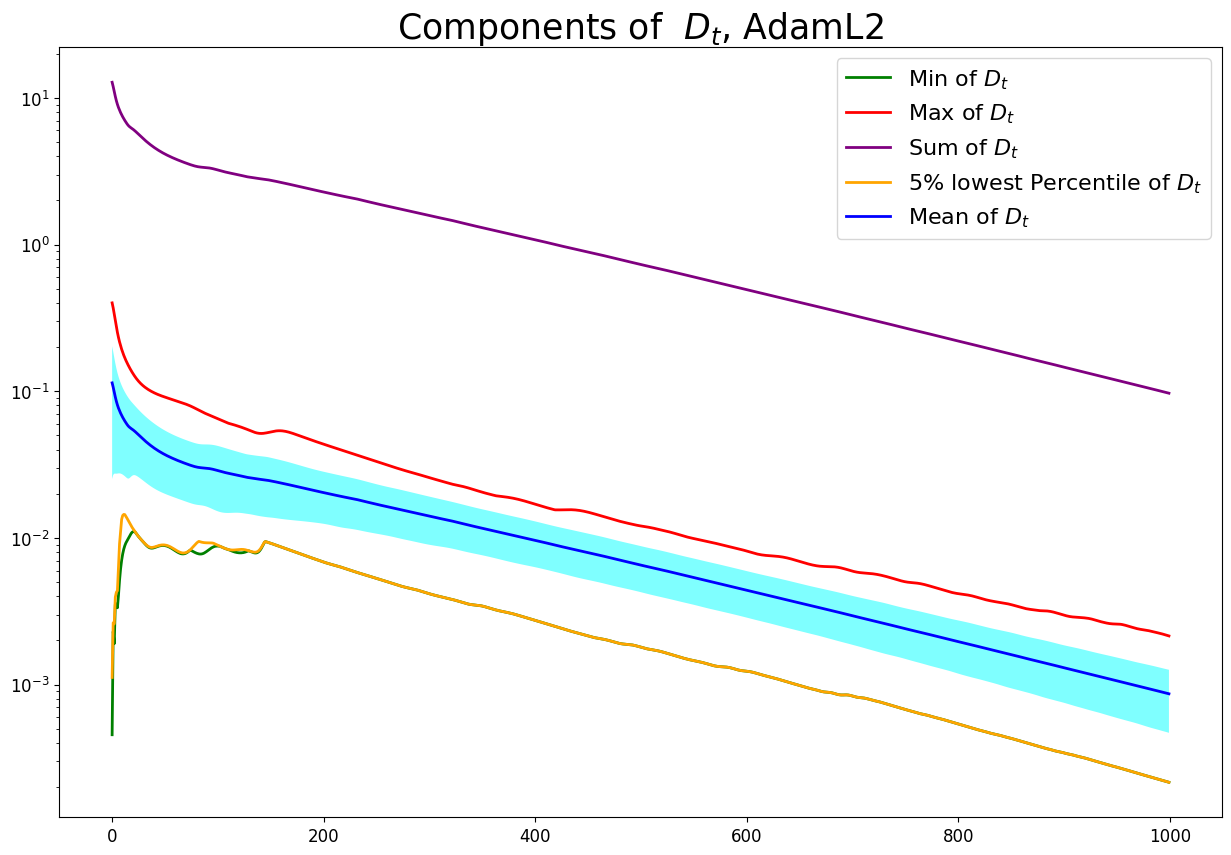

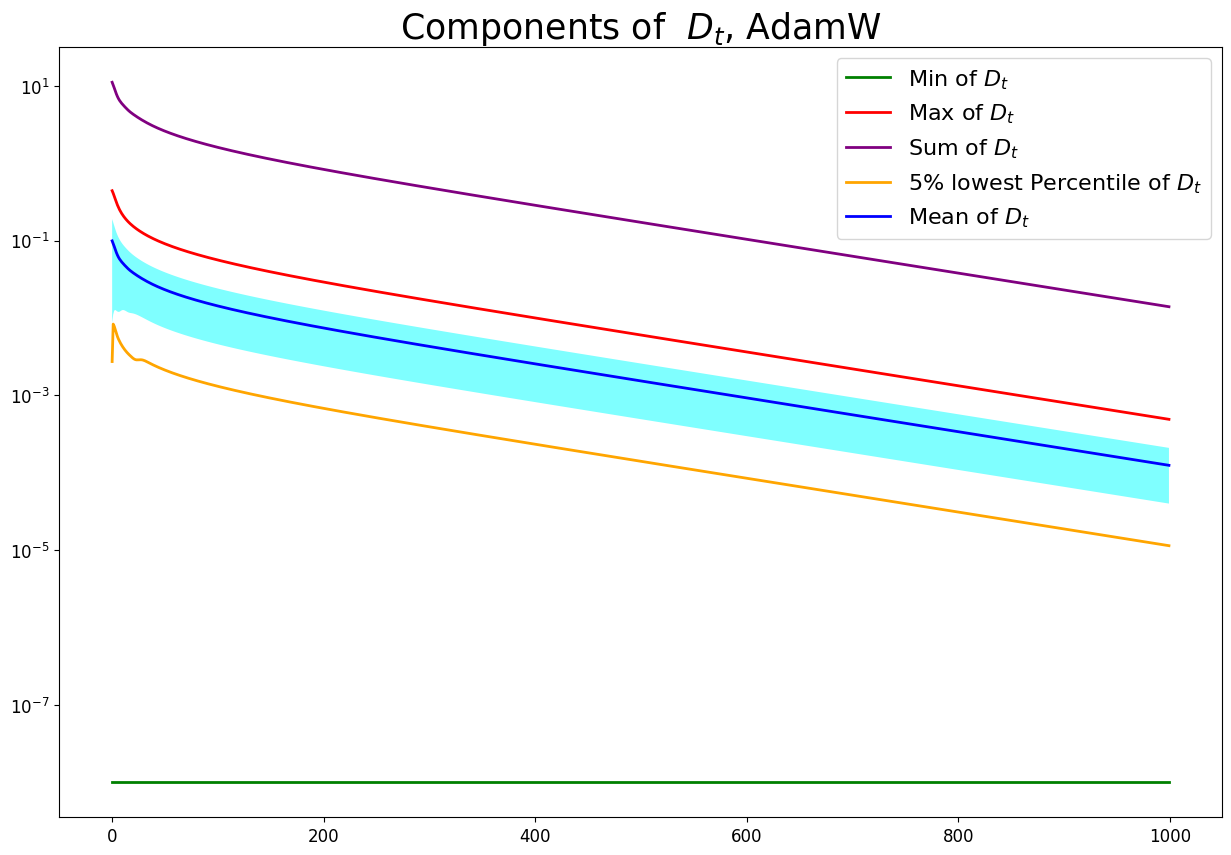

In [30]:
draw_pictures([i for i in range(1000)], M1.get_D_t(), ', AdamL2')
draw_pictures([i for i in range(1000)], M2.get_D_t(), ', AdamW')

In [7]:
from tqdm import tqdm
def get_data():
    data = load_svmlight_file("mushrooms.txt")
    X, y = data[0].toarray(), data[1]
    y = y * 2 - 3
    n, d = X.shape
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    return X_train, y_train
    
def get_mean_std_converge():
    y_plots1, y_plots2 = [], []
    for i in tqdm(range(10)):
        X, y = get_data()
        
        M1 = Model(d)
        M1.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
        x_plot1, y_plot1 = M1.get_converge_iteration()
        y_plots1.append(y_plot1)
        
        M2 = Model(d)
        M2.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
        x_plot2, y_plot2 = M2.get_converge_iteration()
        y_plots2.append(y_plot2)
    y_plots1 = np.vstack(y_plots1)
    y_plots2 = np.vstack(y_plots2)
    
    return x_plot1, np.mean(y_plots1, axis=0), np.mean(y_plots2, axis=0), np.std(y_plots1, axis=0), np.std(y_plots2, axis=0)

In [67]:
x, y_mean1, y_mean2, y_std1, y_std2 = get_mean_std()

100%|██████████| 10/10 [21:42<00:00, 130.26s/it]


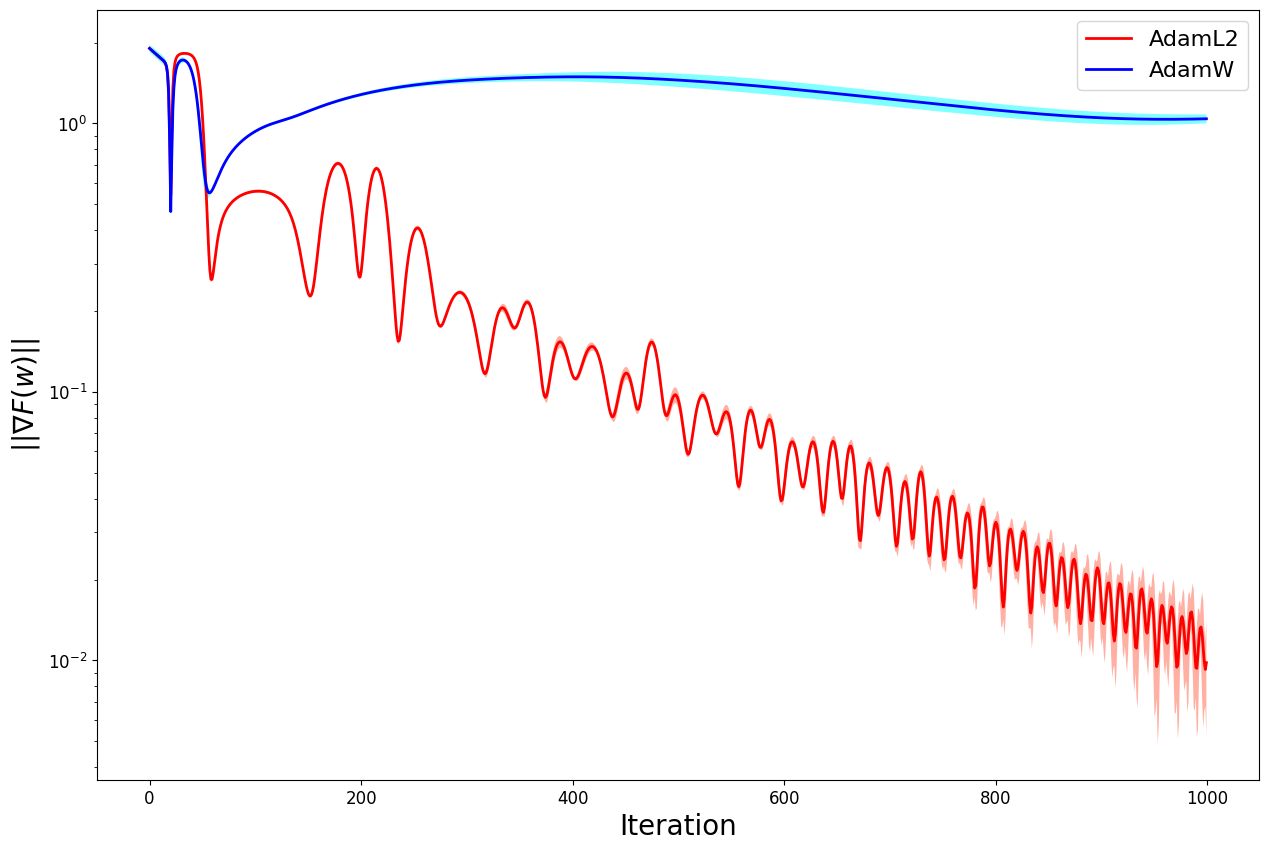

In [92]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla F(w)||$")

plt.semilogy(x, y_mean1, linewidth=linewidth, label=r"AdamL2", color='red')
plt.fill_between(x, y_mean1+3*y_std1, y_mean1-3*y_std1, facecolor='tomato', alpha=0.5)


plt.semilogy(x, y_mean2, linewidth=linewidth, label=M2.label, color='blue')
plt.fill_between(x, y_mean2+10*y_std2, y_mean2-10*y_std2, facecolor='aqua', alpha=0.5)

plt.legend()

plt.savefig("./pictures/fig1.jpg")
plt.show()

# AdamW does not converge

In [95]:
def get_mean_std_converge():
    y_plots1, y_plots2 = [], []
    for i in tqdm(range(10)):
        X, y = get_data()

        M1 = Model(d)
        M1.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
        x_plot1, y_plot1 = M1.get_converge_iteration()
        y_plots1.append(y_plot1)
        
        M2 = Model(d)
        M2.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params,special_convergence=True)
        x_plot2, y_plot2 = M2.get_converge_iteration()
        y_plots2.append(y_plot2)
        
    y_plots1 = np.vstack(y_plots1)
    y_plots2 = np.vstack(y_plots2)
    
    return x_plot1, np.mean(y_plots1, axis=0), np.mean(y_plots2, axis=0), np.std(y_plots1, axis=0), np.std(y_plots2, axis=0)
x_conv, y_mean1_conv, y_mean2_conv, y_std1_conv, y_std2_conv = get_mean_std_converge()

100%|██████████| 10/10 [21:50<00:00, 131.10s/it]


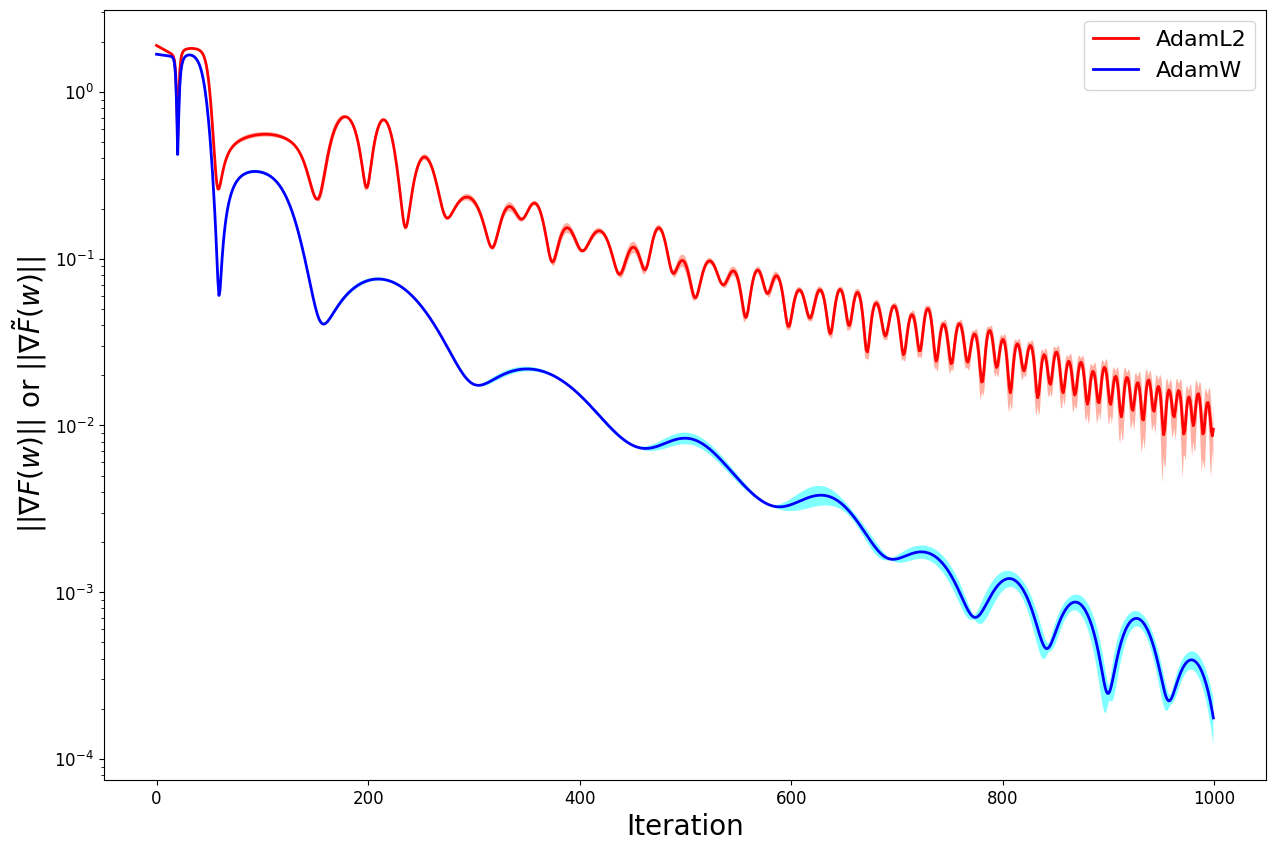

In [106]:

plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel(r'$||\nabla F(w)||$ or $||\nabla \tilde{F}(w) ||$')

plt.semilogy(x_conv, y_mean1_conv, linewidth=linewidth, label=r"AdamL2", color='red')
plt.fill_between(x_conv, y_mean1_conv+5*y_std1_conv, y_mean1_conv-5*y_std1_conv, facecolor='tomato', alpha=0.5)

plt.semilogy(x_conv, y_mean2_conv, linewidth=linewidth, label=M2.label, color='blue')
plt.fill_between(x_conv, y_mean2_conv+2*y_std2_conv, y_mean2_conv-2*y_std2_conv, facecolor='aqua', alpha=0.5)

plt.legend()

plt.savefig("./pictures/fig2.jpg")
plt.show()

In [10]:
steps = 1000
params = (0.99, 0.99, 1e-8)

M1 = Model(d)
M1.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot1, y_plot1 = M1.get_converge_iteration()

M2 = Model(d)
M2.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot2, y_plot2 = M2.get_converge_iteration()

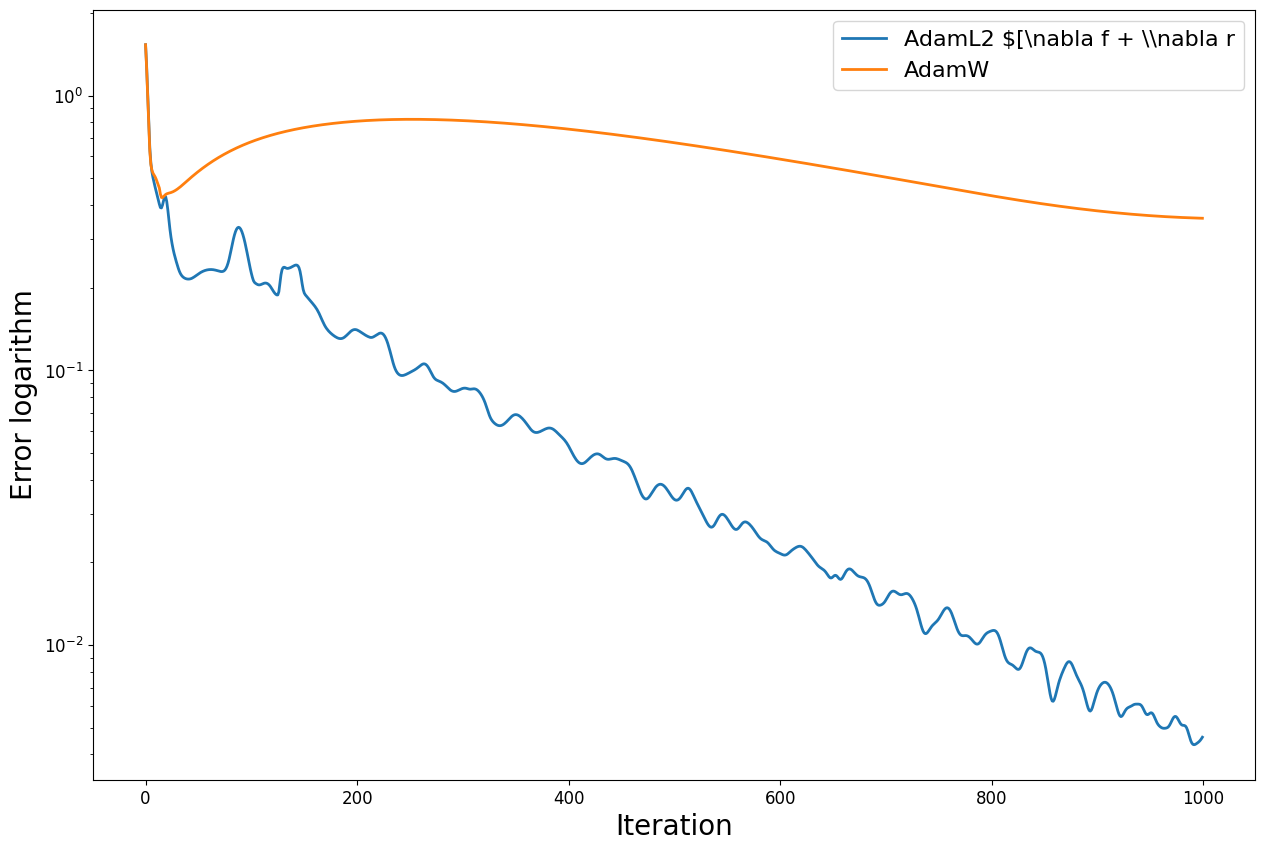

In [38]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel("Error logarithm")
#plt.ylabel(r'$||\nabla f(w_t) + \nabla r(w_t)||$')


plt.semilogy(x_plot1, y_plot1, linewidth=linewidth, label=r"AdamL2 $[\nabla f + \\nabla r")
plt.semilogy(x_plot2, y_plot2, linewidth=linewidth, label=M2.label)

plt.legend()

# plt.savefig("/fig1.jpg")
plt.show()

# Special conveergence

100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


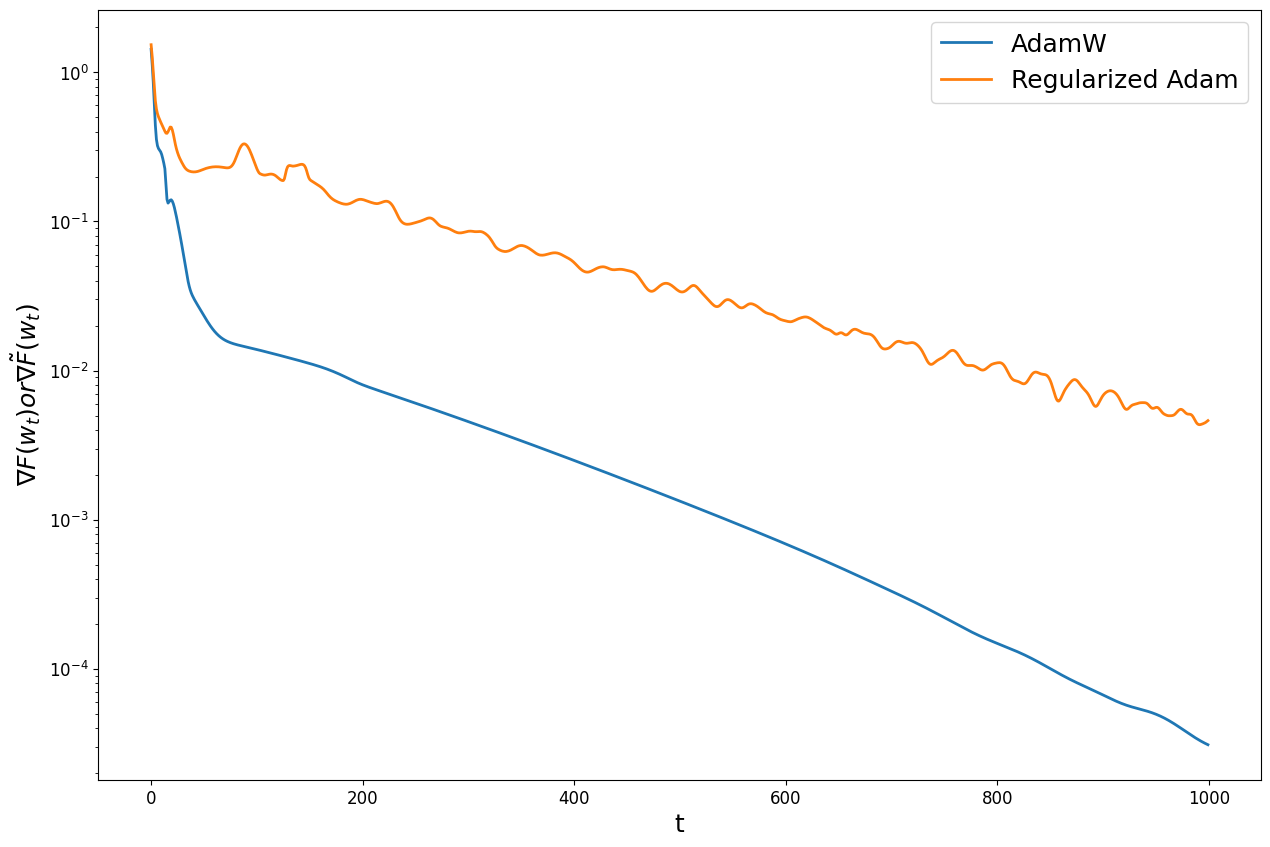

In [9]:
steps = 1000
params = (0.99, 0.99, 1e-8)

M = Model(d)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("t", fontsize=font)
plt.ylabel(r'$\nabla F(w_t) or \nabla \tilde{F}(w_t)$', fontsize=font)

M.AdamW(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params, special_convergence=True)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, linewidth=linewidth, label=M.label)

M.AdamL2(X, y, weight_decay=0.04, learning_rate=0.05, steps=steps, params=params)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, linewidth=linewidth, label=M.label)

plt.legend(fontsize=font)

# plt.savefig("/fig1.jpg")
plt.show()

## OASIS investigation

In [163]:
class Model_oasis:
    def __init__(self, d):
        self.d = d
        self.w = np.zeros(d)

        self.converge = []

        self.write_time = False
        self.times = []
        self.operations = []
        self.operations_done = 0
        self.label = ""

        self.D_ts = []
    
    def reset(self):
        self.w = np.ones(self.d)
        self.converge = []
        self.times = []
        self.D_ts = []
        self.operations = []
        self.operations_done = 0

    def OASISL2(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, params=[0.99, 0.999, 1e-8], batch_size=None):
        self.reset()
        self.label = "Regularized Adam"
        if batch_size is None:
            batch_size = X.shape[0]

        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)
        theta, lr_prev= 1, learning_rate
        w_prev, grad_prev = self.w, np.zeros_like(self.w)
        
        for i in tqdm(range(steps), disable=True):
            grad = grad_f(self.w, X, y, batch_size) + weight_decay * self.w
            grad_grad = grad_grad_f(self.w, X, y, batch_size)
            grad_grad = np.max([grad_grad, 1e-3*np.ones_like(grad_grad)], axis=0)
            self.converge.append(np.linalg.norm(grad))
            # update D_t and g_t
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad_grad)
            
            m_bias_corr = m
            v_bias_corr = v
            
            lr_prev = learning_rate
            
            self.D_ts.append(np.sqrt(v_bias_corr) + eps)
            self.w = self.w - learning_rate * m_bias_corr/v_bias_corr

    def OASISW(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, special_convergence=False, params=[0.99, 0.999, 1e-8], batch_size=None):
        self.reset()
        self.label = "AdamW"
        if batch_size is None:
            batch_size = X.shape[0]
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.ones(self.d)
        v = np.ones(self.d)
        theta, lr_prev= 0, learning_rate
        w_prev, grad_prev = self.w, np.zeros_like(self.w)

        grad = np.ones(self.d)
        for i in tqdm(range(steps), disable=True):
            grad = grad_f(self.w, X, y, batch_size) 
            grad_grad = grad_grad_f(self.w, X, y, batch_size)
            grad_grad = np.max([grad_grad, 1e-2*np.ones_like(grad_grad)], axis=0)
            # update D_t and g_t
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad_grad)

            # костыль для удобства
            m_bias_corr = m
            v_bias_corr = v
            lr_prev = learning_rate
         
            if special_convergence:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay * v_bias_corr))
            else:
                self.converge.append(np.linalg.norm(grad + self.w * weight_decay))
            self.w = self.w - learning_rate * m_bias_corr/v_bias_corr# - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)
    
    def GD(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0):
        self.reset()
        self.label = "GD"

        if self.write_time:
            self.time_start = dt.now()

        for _ in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
            grad = grad + weight_decay * self.w

            self.w = self.w - learning_rate * grad
            self.converge.append(np.linalg.norm(grad))

    def get_converge_iteration(self):
        x_plot = range(len(self.converge))
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_converge_operations(self):
        x_plot = self.operations
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_D_t(self):
        return self.D_ts

In [176]:
steps = 1000
params = (0.99, 0.99, 1e-8)
from tqdm import tqdm
def get_data():
    data = load_svmlight_file("mushrooms.txt")
    X, y = data[0].toarray(), data[1]
    y = y * 2 - 3
    n, d = X.shape
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    return X_train, y_train
    
def get_mean_std_converge():
    y_plots1, y_plots2 = [], []
    for i in tqdm(range(10)):
        X, y = get_data()
        
        M1 = Model_oasis(d)
        M1.OASISL2(X, y, weight_decay=1e-2, learning_rate=1e-3, steps=steps, params=params, batch_size=1000)
        x_plot1, y_plot1 = M1.get_converge_iteration()
        y_plots1.append(y_plot1)
        
        M2 = Model_oasis(d)
        M2.OASISW(X, y, weight_decay=1e-1, learning_rate=1e-2, steps=steps, params=params, special_convergence=False, batch_size=1000)
        x_plot2, y_plot2 = M2.get_converge_iteration()
        y_plots2.append(y_plot2)
    y_plots1 = np.vstack(y_plots1)
    y_plots2 = np.vstack(y_plots2)
    
    return x_plot1, np.mean(y_plots1, axis=0), np.mean(y_plots2, axis=0), np.std(y_plots1, axis=0), np.std(y_plots2, axis=0)

In [177]:
x, y_mean1, y_mean2, y_std1, y_std2 = get_mean_std_converge()

100%|██████████| 10/10 [06:41<00:00, 40.15s/it]


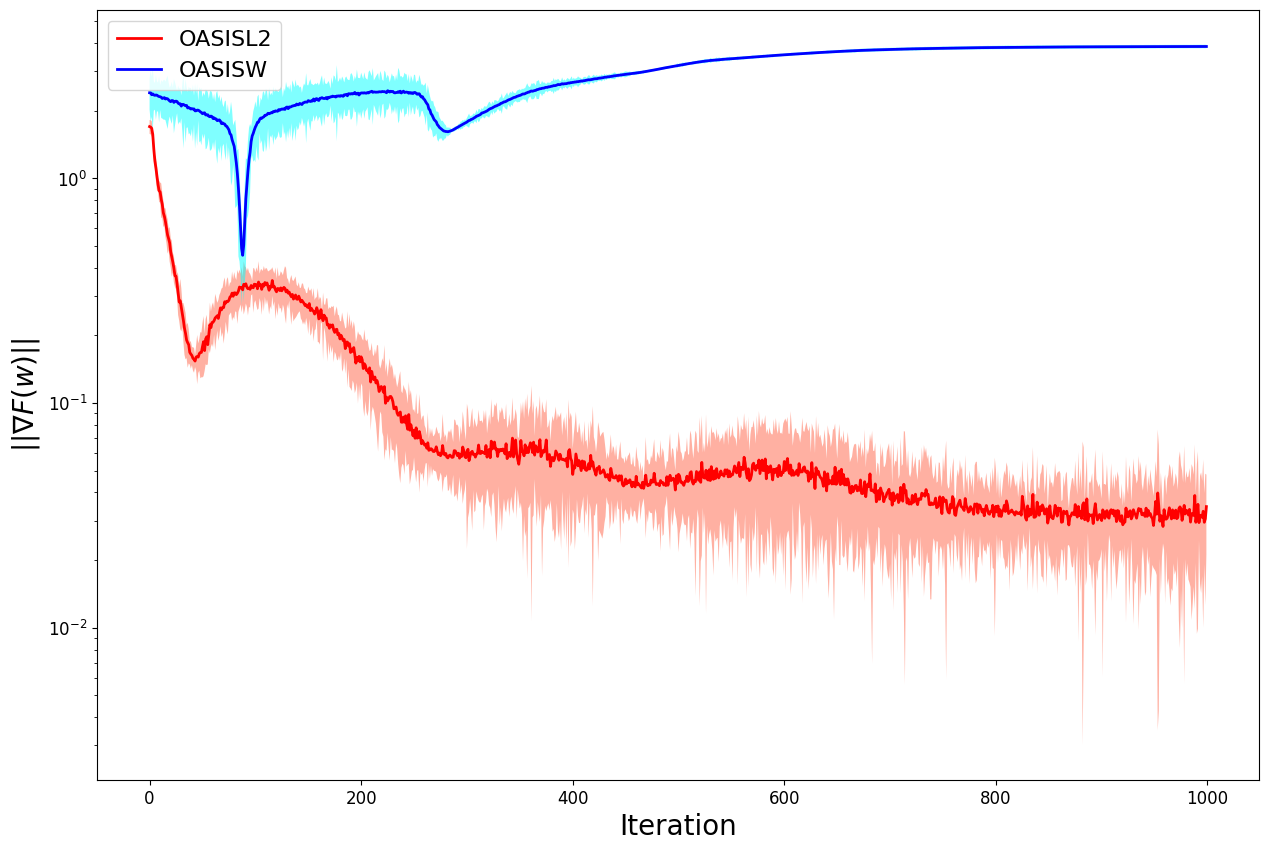

In [183]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla F(w)||$")
plt.semilogy(x, y_mean1, linewidth=linewidth, label=r"OASISL2", color='red')
plt.fill_between(x, y_mean1+3*y_std1, y_mean1-3*y_std1, facecolor='tomato', alpha=0.5)

plt.semilogy(x, y_mean2, linewidth=linewidth, label=r"OASISW", color='blue')
plt.fill_between(x, y_mean2+10*y_std2, y_mean2-10*y_std2, facecolor='aqua', alpha=0.5)

plt.legend()

plt.savefig("./pictures/fig1_oasis.jpg")
plt.show()

In [178]:
def get_mean_std_converge():
    y_plots1, y_plots2 = [], []
    for i in tqdm(range(10)):
        X, y = get_data()
        
        M1 = Model_oasis(d)
        M1.OASISL2(X, y, weight_decay=1e-2, learning_rate=1e-4, steps=steps, params=params, batch_size=1000)
        x_plot1, y_plot1 = M1.get_converge_iteration()
        y_plots1.append(y_plot1)
        
        M2 = Model_oasis(d)
        M2.OASISW(X, y, weight_decay=1e-1, learning_rate=1e-2, steps=steps, params=params, special_convergence=True, batch_size=1000)
        x_plot2, y_plot2 = M2.get_converge_iteration()
        y_plots2.append(y_plot2)
    y_plots1 = np.vstack(y_plots1)
    y_plots2 = np.vstack(y_plots2)
    
    return x_plot1, np.mean(y_plots1, axis=0), np.mean(y_plots2, axis=0), np.std(y_plots1, axis=0), np.std(y_plots2, axis=0)

In [179]:
x_conv, y_mean1_conv, y_mean2_conv, y_std1_conv, y_std2_conv = get_mean_std_converge()

100%|██████████| 10/10 [06:39<00:00, 39.91s/it]


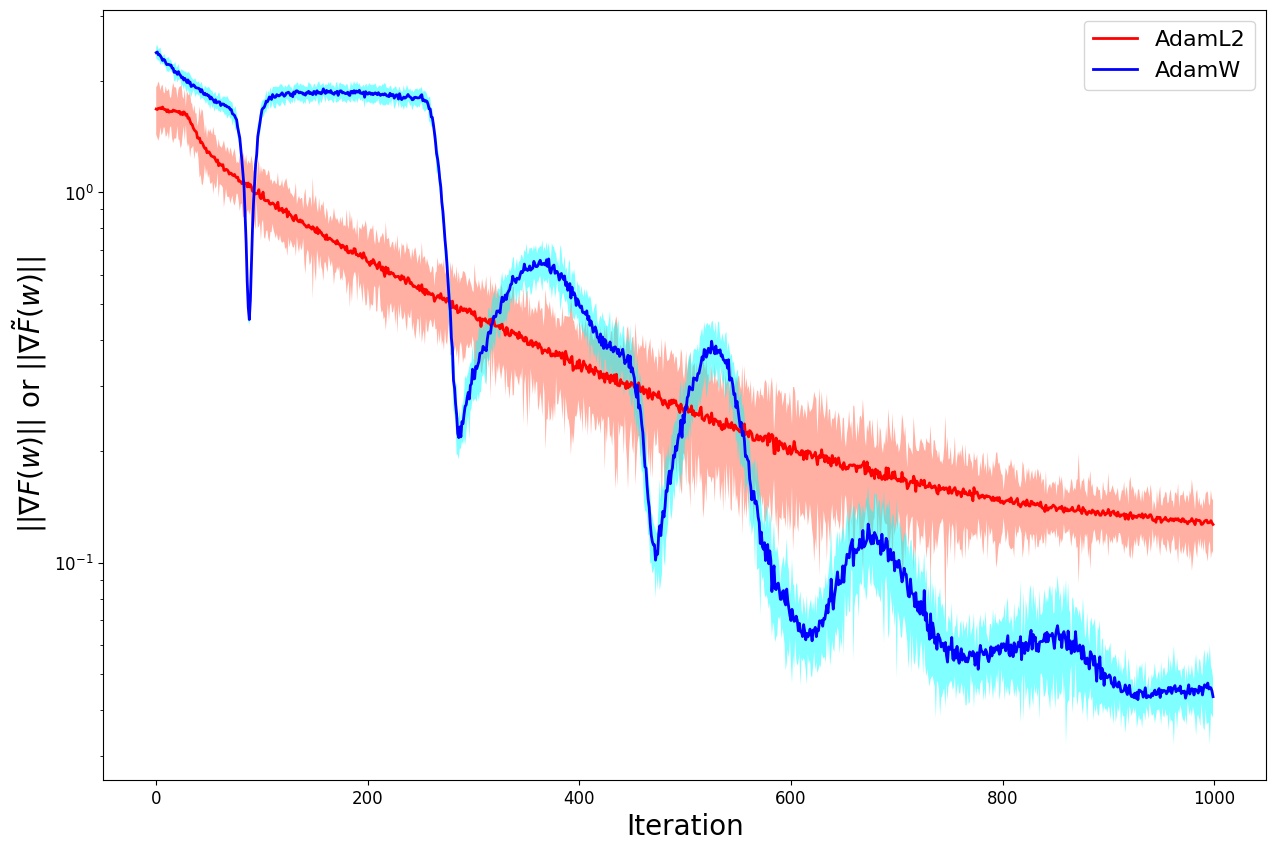

In [182]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(15, 10))
plt.tick_params(axis='both', which='major', labelsize=12)

font = 18
linewidth = 2

plt.xlabel("Iteration")
plt.ylabel(r'$||\nabla F(w)||$ or $||\nabla \tilde{F}(w) ||$')

plt.semilogy(x_conv, y_mean1_conv, linewidth=linewidth, label=r"AdamL2", color='red')
plt.fill_between(x_conv, y_mean1_conv+5*y_std1_conv, y_mean1_conv-5*y_std1_conv, facecolor='tomato', alpha=0.5)

plt.semilogy(x_conv, y_mean2_conv, linewidth=linewidth, label=M2.label, color='blue')
plt.fill_between(x_conv, y_mean2_conv+2*y_std2_conv, y_mean2_conv-2*y_std2_conv, facecolor='aqua', alpha=0.5)

plt.legend()

plt.savefig("./pictures/fig2_oasis.jpg")
plt.show()